# SD212: Graph mining
## Solution to Lab 5: Heat diffusion

In this lab, you will learn to use diffusion for **contrastive ranking** and **classification** of nodes.

## Import

In [1]:
from IPython.display import SVG

In [2]:
import numpy as np
from scipy import sparse

In [3]:
from sknetwork.data import load_netset, grid, karate_club
from sknetwork.regression import Dirichlet
from sknetwork.classification import DiffusionClassifier
from sknetwork.ranking import PageRank
from sknetwork.visualization import svg_graph

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr/) collection for details):
* Openflights (graph)
* WikiVitals (directed graph + bipartite graph)

In [4]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')

Parsing files...
Done.
Parsing files...
Done.


## 1. Graphs

## Grid

We first illustrate the notion of contrastive ranking on a $k\times k$ grid.

In [5]:
k = 5
dataset = grid(k, k, True)
adjacency = dataset.adjacency
position = dataset.position

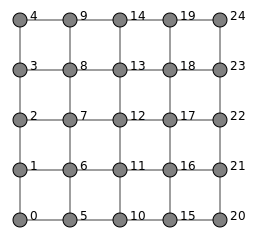

In [6]:
image = svg_graph(adjacency, position, names=np.arange(k * k), width=200, height=200)
SVG(image)

## To do

* Display the graph with 1 cold source and 1 hot source, at the bottom-left and top-right corners of the square.
* Add a hot source at the top-left corner of the square. What is the free node of highest temperature?

In [7]:
dirichlet = Dirichlet()

In [8]:
bottom_left = 0
top_right = k * k - 1

In [9]:
values = {bottom_left: 0, top_right: 1}

In [10]:
temperatures = dirichlet.fit_predict(adjacency, values=values)

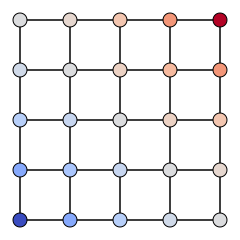

In [11]:
image = svg_graph(adjacency, position, scores=temperatures, width=200, height=200)
SVG(image)

In [12]:
top_left = k - 1

In [13]:
values[top_left] = 1

In [14]:
temperatures = dirichlet.fit_predict(adjacency, values=values)

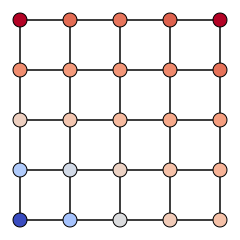

In [15]:
image = svg_graph(adjacency, position, scores=temperatures, width=200, height=200)
SVG(image)

In [16]:
mask = np.ones(k * k, dtype=bool)
mask[list(values)] = 0
i = np.argmax(temperatures[mask])
hot = np.flatnonzero(mask)[i]

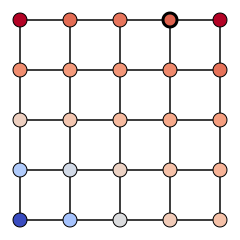

In [17]:
image = svg_graph(adjacency, position, scores=temperatures, seeds=hot, width=200, height=200)
SVG(image)

## Karate Club


We now consider the classification of nodes by heat diffusion. We use the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) that has ground-truth labels.

In [18]:
dataset = karate_club(True)

In [19]:
adjacency = dataset.adjacency
position = dataset.position
labels_true = dataset.labels

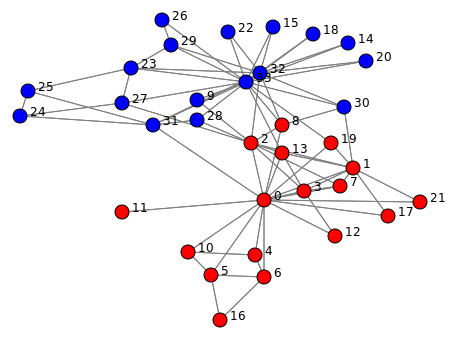

In [20]:
image = svg_graph(adjacency, position, labels=labels_true, names=np.arange(len(labels_true)))
SVG(image)

## To do

* Select one node in each ground-truth cluster, and predict the labels of the other nodes by heat diffusion.
* Display the graph with the predicted labels. 
* What is the accuracy of the classification?

In [21]:
classifier = DiffusionClassifier()

In [22]:
# train set
labels = labels_true.copy()
seeds = np.array([12, 29])
mask = np.zeros(len(labels), dtype=bool)
mask[seeds] = 1
labels[~mask] = -1

In [23]:
labels_pred = classifier.fit_predict(adjacency, labels)

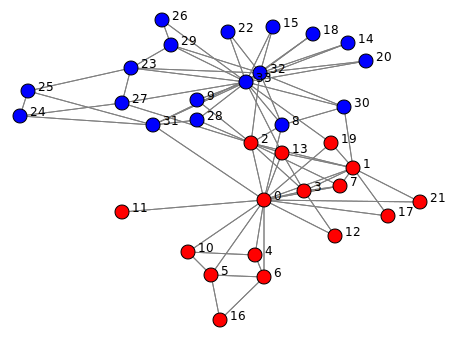

In [24]:
image = svg_graph(adjacency, position, labels=labels_pred, names=np.arange(len(labels_true)))
SVG(image)

In [25]:
# accuracy
np.mean(labels_true[~mask]==labels_pred[~mask])

0.96875

## To do

The classifier applies temperature centering after diffusion.

* Repeat the same experiment without temperature centering.
* Do the same experiments with 3 nodes in a ground-truth label and 1 in the other.
* What is your conclusion?

In [26]:
classifier = DiffusionClassifier(centering=False)

In [27]:
labels_pred = classifier.fit_predict(adjacency, labels)

In [28]:
# accuracy
np.mean(labels_true==labels_pred)

0.9117647058823529

In [29]:
# train set
labels = labels_true.copy()
seeds = np.array([0, 12, 19, 29])
mask = np.zeros(len(labels), dtype=bool)
mask[seeds] = 1
labels[~mask] = -1

In [30]:
labels[seeds]

array([1, 1, 1, 0])

In [31]:
labels_pred = classifier.fit_predict(adjacency, labels)
np.mean(labels_true==labels_pred)

0.5882352941176471

In [32]:
classifier = DiffusionClassifier(centering=True)

In [33]:
labels_pred = classifier.fit_predict(adjacency, labels)
np.mean(labels_true==labels_pred)

0.9705882352941176

## Openflights


We now show how to classify the nodes of a graph **without labels**, through human labelling of a few nodes.

In [34]:
dataset = openflights

In [35]:
adjacency = dataset.adjacency
position = dataset.position
names = dataset.names

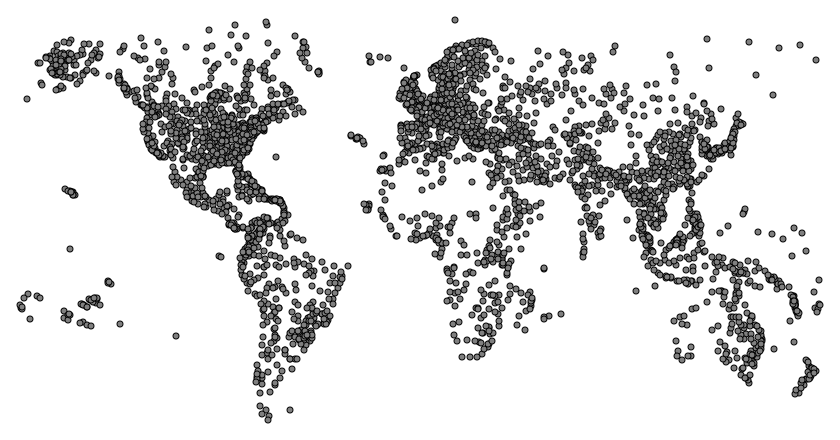

In [36]:
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the same world map with the labels predicted given 3 nodes (Paris, New-York, Beijing), each with its own  label.
* Add Madrid with another label and observe the result.

In [37]:
paris = 622
newyork = 1842
beijing = 1618

In [38]:
classifier = DiffusionClassifier()

In [39]:
labels = {paris: 0, newyork: 1, beijing: 2}

In [40]:
labels_pred = classifier.fit_predict(adjacency, labels)

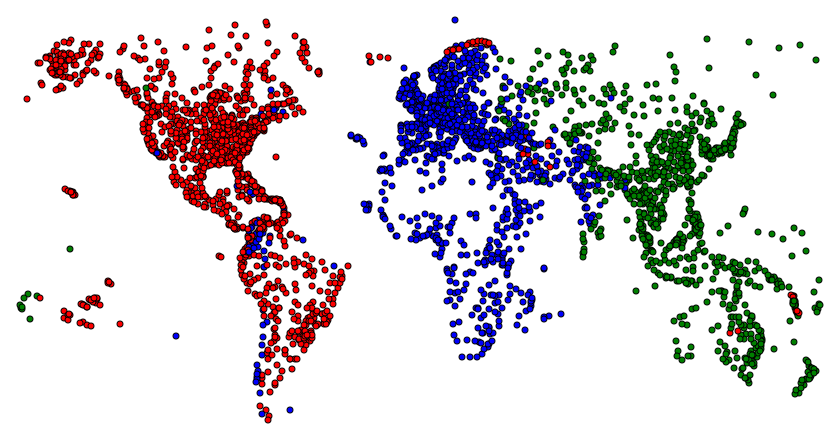

In [41]:
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, labels=labels_pred, display_edges=False)
SVG(image)

In [42]:
madrid = 572

In [43]:
labels[madrid] = 3

In [44]:
labels_pred = classifier.fit_predict(adjacency, labels)

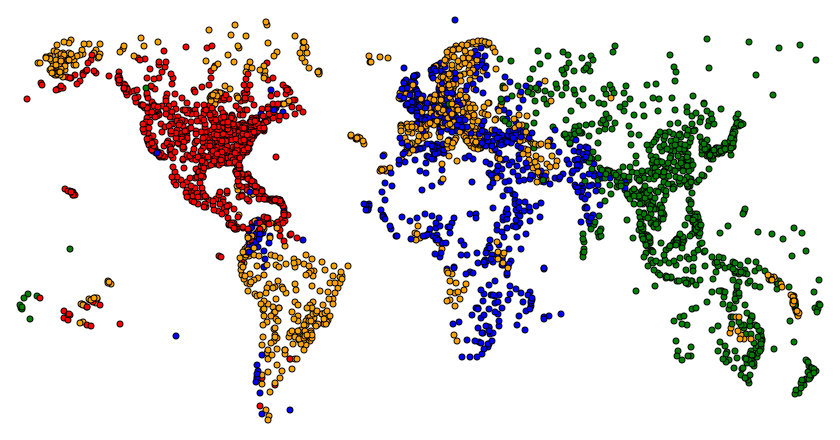

In [45]:
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, labels=labels_pred, display_edges=False)

SVG(image)

## To do

* List the top-10 airports that are close to Tokyo in terms of Personalized PageRank.
* List of the top-10 airports that are close to Tokyo and far from Paris Charles de Gaulle, using heat diffusion (contrastive ranking).<br> What do you observe?
* Display the temperatures of these airports after heat diffusion and explain the result.

In [46]:
pagerank = PageRank()

In [47]:
tokyo = 1084

In [48]:
scores = pagerank.fit_predict(adjacency, weights={tokyo:1})

In [49]:
top_pagerank = np.argsort(-scores)[:10]

In [50]:
print(names[top_pagerank])

['Tokyo Haneda International Airport' 'Incheon International Airport'
 'Naha Airport' 'Taiwan Taoyuan International Airport'
 'Osaka International Airport' 'Shanghai Pudong International Airport'
 'New Chitose Airport' 'Kansai International Airport'
 'Narita International Airport' 'Chubu Centrair International Airport']


In [51]:
dirichlet = Dirichlet()

In [52]:
tokyo = 1084

In [53]:
values = {paris:0, tokyo: 1}

In [54]:
values = dirichlet.fit_predict(adjacency, values)

In [55]:
top_diffusion = np.argsort(-values)[:10]

In [56]:
print(names[top_diffusion])

['Kitakyūshū Airport' 'Tokushima Airport' 'Tokachi-Obihiro Airport'
 'Oshima Airport' 'Tokyo Haneda International Airport' 'Tottori Airport'
 'Hachijojima Airport' 'Izumo Airport' 'Monbetsu Airport' 'Shonai Airport']


In [57]:
# no common node (except Tokyo)
len(set(list(top_pagerank)) & set(list(top_diffusion)))

1

In [58]:
values[top_diffusion]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

These airports are connected to Paris through Tokyo only.

## 2. Directed graphs

We now consider the graph of links of WikiVitals. We first focus on constrastive ranking, then on node classification.

## Wikipedia Vitals

In [59]:
dataset = wikivitals

In [60]:
adjacency = dataset.adjacency
names = dataset.names
labels = dataset.labels
names_labels = dataset.names_labels

## Ranking

## To do

* List the top-10 articles that are close to **Cat** and **Dog** in terms of Personalized PageRank, considering the graph as bipartite.
* Compare with the list of top-10 articles that are close to **Cat** and **Dog** and far from **Bear** and **Tiger** using heat diffusion (contrastive ranking).
* List the top-10 articles that are close to **Bear** and **Tiger** and far from **Cat** and **Dog** (you can use previous diffusion). Interpret the results.

In [61]:
pagerank = PageRank()

In [62]:
cat = int(np.flatnonzero(names=='Cat'))
dog = int(np.flatnonzero(names=='Dog'))

In [63]:
scores = pagerank.fit_predict(adjacency, weights={cat:1, dog:1}, force_bipartite=True)

In [64]:
top_pagerank = np.argsort(-scores)[:10]
print(names[top_pagerank])

['Dog' 'Cat' 'Wolf' 'Coyote' 'European badger' 'Lion' 'Tiger' 'Leopard'
 'Cougar' 'Brown bear']


In [65]:
diffusion = Dirichlet()

In [66]:
bear = int(np.flatnonzero(names=='Bear'))
tiger = int(np.flatnonzero(names=='Tiger'))

In [67]:
values = diffusion.fit_predict(adjacency, values={cat:1, dog:1, bear:0, tiger:0})

In [68]:
top_diffusion = np.argsort(-values)[:10]
print(names[top_diffusion])

['Cat' 'Dog' 'Terrier' 'Retriever' 'Great Dane' 'Mouse' 'Moulting' 'Skink'
 'Lyrebird' 'Budgerigar']


In [69]:
bottom_diffusion = np.argsort(values)[:10]
print(names[bottom_diffusion])

['Bear' 'Gloss (optics)' 'Tiger' 'Goby' 'Serranidae' 'Endangered species'
 'Hibernation' 'Malay Peninsula' 'Taxidermy' 'Legendary creature']


The articles 'Gloss (optics)' and 'Goby' are sinks: their temperatures remain constant (here 0).

In [70]:
values[bottom_diffusion]

array([0.        , 0.        , 0.        , 0.        , 0.46026658,
       0.47265623, 0.47451533, 0.47769443, 0.48191133, 0.4848536 ])

In [71]:
from sknetwork.utils import get_degrees
out_degrees = get_degrees(adjacency)
out_degrees[bottom_diffusion]

array([113,   0, 166,   0,  12,  19,  19,  23,  27,  32])

## Node classification

## To do

* What is the accuracy of node classification, using half of the nodes in the train set?
* Compare with the accuracy obtained on the undirected graph.

In [72]:
dataset = wikivitals
adjacency = dataset.adjacency
labels_true = dataset.labels

In [73]:
algo = DiffusionClassifier()

In [74]:
# train set
labels = labels_true.copy()
mask = np.random.random(size=len(labels_true)) < 0.5
labels[~mask] = -1

In [75]:
labels_pred = algo.fit_predict(adjacency, labels)

In [76]:
np.mean(labels_pred[~mask]==labels_true[~mask])

0.6974789915966386

In [77]:
from sknetwork.utils import directed2undirected

In [78]:
adjacency_ = directed2undirected(adjacency)

In [79]:
labels_pred = algo.fit_predict(adjacency_, labels)

In [80]:
np.mean(labels_pred[~mask]==labels_true[~mask])

0.7382953181272509

## To do

* Classify each article of the **People** category in one of the other categories (Mathematics, History, etc.), using all other labels.
* List top-5 people of each category using PageRank.

In [81]:
print(names_labels)

['Arts' 'Biological and health sciences' 'Everyday life' 'Geography'
 'History' 'Mathematics' 'People' 'Philosophy and religion'
 'Physical sciences' 'Society and social sciences' 'Technology']


In [82]:
labels = labels_true.copy()
labels[labels == 6] = -1

In [83]:
labels_pred = algo.fit_predict(adjacency_, labels)

In [84]:
for label in np.unique(labels_true):
    if label != 6:
        pagerank = PageRank()
        mask = (labels_pred==label)&(labels_true==6)
        scores = pagerank.fit_predict(adjacency, mask, force_bipartite=True)
        scores *= mask
        print(names_labels[label], f'({np.sum(mask)})')
        print(names[np.argsort(-scores)[:5]])
        print('---')    

Arts (543)
['Bob Dylan' 'Barbra Streisand' 'Fred Astaire' 'Judy Garland'
 'Leonard Bernstein']
---
Biological and health sciences (34)
['Antonie van Leeuwenhoek' 'Konrad Lorenz' 'James Watson' 'Francis Crick'
 'Charles Darwin']
---
Everyday life (21)
['Wayne Gretzky' 'LeBron James' 'Willie Mays' 'Jackie Robinson'
 'Jim Thorpe']
---
Geography (344)
['Carl Lewis' 'Martina Navratilova' 'Steffi Graf' 'Pelé'
 'Ronaldo (Brazilian footballer)']
---
History (384)
['Alexander the Great' 'Charlemagne' 'Augustus' 'Winston Churchill'
 'Napoleon']
---
Mathematics (42)
['Leonhard Euler' 'Bernhard Riemann' 'Henri Poincaré' 'Archimedes'
 'Emmy Noether']
---
Philosophy and religion (253)
['Augustine of Hippo' 'Thomas Aquinas' 'Plato' 'Aristotle' 'Immanuel Kant']
---
Physical sciences (110)
['Marie Curie' 'Isaac Newton' 'Albert Einstein' 'J. J. Thomson'
 'Carl Friedrich Gauss']
---
Society and social sciences (224)
['Noam Chomsky' 'Thomas Jefferson' 'Karl Marx' 'Ralph Waldo Emerson'
 'John Stuart Mill']

## 3. Bipartite graphs

Finally, we consider the bipartite graph between articles and words.

In [85]:
dataset = wikivitals

In [86]:
biadjacency = dataset.biadjacency

## To do

* Repeat the experiments on node classification using the bipartite graph between articles and words.
* Which information seems to be richer, the text or the links between articles?
* Propose a solution exploiting both sources of information.

In [87]:
algo = DiffusionClassifier()

In [88]:
# train set
labels = labels_true.copy()
mask = np.random.random(size=len(labels_true)) < 0.5
labels[~mask] = -1

In [89]:
labels_pred = algo.fit_predict(biadjacency, labels)

In [90]:
# better accuracy
np.mean(labels_pred[~mask]==labels_true[~mask])

0.8058953278524162

In [91]:
# concatenation
full_matrix = sparse.hstack((adjacency, biadjacency))
labels_pred = algo.fit_predict(full_matrix, labels)

In [92]:
np.mean(labels_pred[~mask]==labels_true[~mask])

0.8030880288750752

In [93]:
labels = labels_true.copy()
labels[labels == 6] = -1

In [94]:
labels_pred = algo.fit_predict(biadjacency, labels)

In [95]:
for label in np.unique(labels_true):
    if label != 6:
        pagerank = PageRank()
        mask = (labels_pred==label)&(labels_true==6)
        scores = pagerank.fit_predict(biadjacency, mask)
        scores *= mask
        print(names_labels[label], f'({np.sum(mask)})')
        print(names[np.argsort(-scores)[:5]])
        print('---')    

Arts (583)
['Martin Scorsese' 'Frank Sinatra' 'Richard Strauss' 'Woody Allen'
 'Antonín Dvořák']
---
Biological and health sciences (17)
['Joseph Lister' 'Jonas Salk' 'Georges Cuvier' 'Galen' 'Robert Koch']
---
Everyday life (91)
['Lionel Messi' 'Serena Williams' 'Wayne Gretzky' 'Michael Jordan'
 'LeBron James']
---
Geography (117)
['Andrew Mellon' 'Oscar Niemeyer' '14th Dalai Lama' 'Julius Nyerere'
 'Manmohan Singh']
---
History (707)
['Lyndon B. Johnson' 'Charles V, Holy Roman Emperor' 'Subhas Chandra Bose'
 'Franklin D. Roosevelt' 'David Lloyd George']
---
Mathematics (61)
['Stefan Banach' 'Emmy Noether' 'Srinivasa Ramanujan' 'Charles Hermite'
 'Ada Lovelace']
---
Philosophy and religion (133)
['Origen' 'Ānanda' 'Mary Magdalene' 'Malik ibn Anas' 'Ahmad ibn Hanbal']
---
Physical sciences (103)
['Marie Curie' 'Enrico Fermi' 'Otto Hahn' 'Johannes Diderik van der Waals'
 'Max Born']
---
Society and social sciences (137)
['Milton Friedman' 'Franz Boas' 'John D. Rockefeller' 'Donald Trump